# Optimization

## Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
from scipy.optimize import root_scalar

## Define Model Curves

### Pruning vs Accuracy

In [4]:
def get_accuracy(p):
    #boltzman sigmoidal
    
    bottom = -0.01748
    top = 0.8302
    v50 = 88.02
    slope = -2.660
    denom = 1 + np.exp((v50-p)/slope)
    
    acc = bottom + (top/denom)

    return max(acc, 0)

### Pruning vs Model Size

In [4]:
def get_size(p):
    coeffs = [496.7, -706.2, 276.9, 4.020]
    
    return sum(c * p**i for i, c in enumerate(coeffs))

### Pruning vs Inference Time

In [5]:
def get_time(p, device_perf):
    b0 = 0.06386
    b1 = -0.06386
    t = (b0 + b1 * p)*10
    return t - (device_perf*t)

### Plot Curves

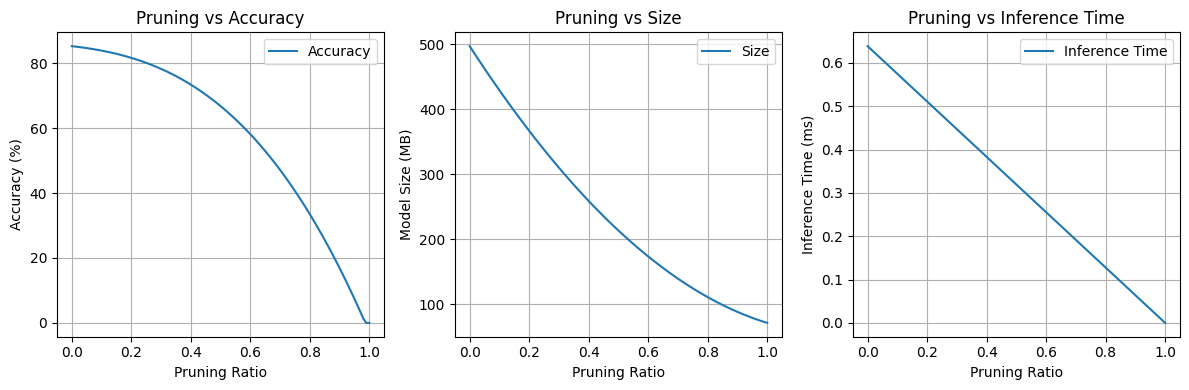

In [6]:
p = np.linspace(0, 1, 100)
sizes = get_size(p)
accuracies = [get_accuracy(p) for p in p]
times = get_time(p=p, device_perf=0)

plt.style.use('default')
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(p, accuracies, label='Accuracy')
plt.xlabel('Pruning Ratio')
plt.ylabel('Accuracy (%)')
plt.title('Pruning vs Accuracy')
plt.grid()
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(p, sizes, label='Size')
plt.xlabel('Pruning Ratio')
plt.ylabel('Model Size (MB)')
plt.title('Pruning vs Size')
plt.grid()
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(p, times, label='Inference Time')
plt.xlabel('Pruning Ratio')
plt.ylabel('Inference Time (ms)')
plt.title('Pruning vs Inference Time')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

## Rewards

### Accuracy Rewards

In [7]:
def get_accuracy_reward(curr_accuracy, min_accuracy, sigma_right=4, sigma_left=2):
    diff = curr_accuracy - min_accuracy
    if 0<=diff<=1e-2:
        return (np.exp(- (diff**2) / (10 * sigma_left**2)) * 100)
    else:
        return 1*(np.exp(- (abs(diff)**1.5) / (2 * sigma_right**2)) * 100)

### Inference Time Reward

In [8]:
def get_comp_time_reward(current_comp_time, sigma=0.8):
    return np.exp(- (current_comp_time**2) / (2 * sigma**2))*10

### Model Size Reward

In [9]:
def get_model_size_reward(current_model_size, max_model_size, sigma_left=2):
    diff = current_model_size - max_model_size
    if current_model_size > max_model_size:
        return np.exp(- ((diff)**2) / (10 * sigma_left**2))*99*0.5
    if current_model_size == max_model_size:
        return 99*(0.5)
    else:
        return (99+(current_model_size/max_model_size))*0.5

### Better Pruning Reward

In [10]:
def more_acc_less_size(accuracy, min_accuracy, size, max_model_size):
    if accuracy >= min_accuracy and size <= max_model_size:
        return ((accuracy-min_accuracy)*2) + (max_model_size-size)/2
    return 0

### Final Reward

In [11]:
def get_reward(p, min_accuracy=80.0, max_model_size=350.0, x=10, y=1, z=1) -> float:
    accuracy = get_accuracy(p)
    time = get_time(p, device_perf=0)
    size = get_size(p)
    
    acc_reward = np.array(get_accuracy_reward(accuracy, min_accuracy))
    time_reward = np.array(get_comp_time_reward(time))
    size_reward = np.array(get_model_size_reward(size, max_model_size))
    better_reward = more_acc_less_size(accuracy, min_accuracy, size, max_model_size)
    # global counts_of_calulating_rewards
    # counts_of_calulating_rewards += 1 # type: ignore
    
    x, y, z = x/(x+y+z), y/(x+y+z), z/(x+y+z)
    
    return np.float64(x*acc_reward + y*time_reward + z*size_reward + better_reward + 0)

## Importance Values

In [12]:
i_org = np.array([0.03044561, 0.02201545, 0.12376647, 0.09755174, 0.04860051,
       0.00832497, 0.03501421, 0.00934147, 0.05674529, 0.15345743,
       0.237974  , 0.17676284])
i = i_org.copy()

## Params

In [13]:
MAX_MODEL_SIZES = [0]*12
GLOBAL_MIN_ACCURACY = 0.0
DEVICES_PERF = [0]*12

In [87]:
def init():
    global MAX_MODEL_SIZES, GLOBAL_MIN_ACCURACY, DEVICES_PERF

    acc_raw = np.random.beta(a=8.0, b=2.0)
    GLOBAL_MIN_ACCURACY = 50.0 + acc_raw * 30.0

    size_multiplier = 1.0 + acc_raw * (4.5 - 1.0)

    MAX_MODEL_SIZES = [100.0 * size_multiplier * np.random.uniform(0.9, 1.1) for _ in range(12)]

    DEVICES_PERF = np.random.uniform(0.0, 0.5, 12)

    print("\n" + "="*60)
    print(f"GLOBAL_MIN_ACCURACY: {GLOBAL_MIN_ACCURACY:.2f}%")
    print(f"SIZE_MULTIPLIER (from beta): {size_multiplier:.2f}")
    print(f"MAX_MODEL_SIZES: {np.round(MAX_MODEL_SIZES, 2)}")
    print(f"DEVICES_PERF: {np.round(DEVICES_PERF, 2)}")
    print("="*60)

## Main Optimization

### Problem Def

In [15]:
class MultiViewProblem(Problem):
    def __init__(self):
        super().__init__(
            n_var=12,
            n_obj=13,
            xl=np.zeros(12),
            xu=np.ones(12)
        )

    def _evaluate(self, X, out, *args, **kwargs):
        pop_size, _ = X.shape
        F = np.zeros((pop_size, 13))

        for j in range(12):
            ps = X[:, j]
            vals = np.zeros(pop_size)
            for k, p in enumerate(ps):
                # Use global min accuracy for consistency
                r = get_reward(p, GLOBAL_MIN_ACCURACY, MAX_MODEL_SIZES[j])
                weighted_r = r * i[j]
                vals[k] = -weighted_r  # minimize negative reward
            F[:, j] = vals
        
        worst_time = get_time(0.0, 0.0)
        time_arrs = [get_time(X[:, j], DEVICES_PERF[j]) for j in range(12)]
        max_time = np.max(time_arrs, axis=0)
        F[:, 12] = max_time/worst_time

        out["F"] = F

class SingleObjectiveProblem(Problem):
    def __init__(self):
        super().__init__(n_var=12, n_obj=1, xl=np.zeros(12), xu=np.ones(12))
        # cache worst‐case time once
        self._worst_time = get_time(0.0, device_perf=0)

    def _evaluate(self, X, out, *args, **kwargs):
        pop_size, _ = X.shape
        F = np.zeros((pop_size, 1))

        for k in range(pop_size):
            p_vec        = X[k, :]
            total_reward = 0.0
            penalty      = 0.0
            total_time   = 0.0

            # accumulate reward, penalty, and raw time
            for j, p in enumerate(p_vec):
                acc   = get_accuracy(p)
                size  = get_size(p)
                total_time += get_time(p, device_perf=DEVICES_PERF[j])

                if np.round(size, 2) > np.round(MAX_MODEL_SIZES[j], 2):
                    penalty += (size - MAX_MODEL_SIZES[j])**2 * 100

                total_reward += get_reward(p, GLOBAL_MIN_ACCURACY, MAX_MODEL_SIZES[j]) * i[j]

            # global accuracy penalty
            weighted_acc = np.dot([get_accuracy(p) for p in p_vec], i)
            if np.round(weighted_acc, 2) < np.round(GLOBAL_MIN_ACCURACY, 2):
                penalty += (GLOBAL_MIN_ACCURACY - weighted_acc)**2 * 10000

            # **normalize** mean time BEFORE applying α
            max_time = max([get_time(p, device_perf=DEVICES_PERF[j]) for j, p in enumerate(p_vec)])
            max_time_norm = max_time / self._worst_time
            alpha          = 0.01
            F[k, 0]        = -(total_reward - penalty) + alpha * max_time_norm

        out["F"] = F

### Check if feasible

In [16]:
def is_feasible_corrected(p_vec):
    accs = np.array([get_accuracy(p) for p in p_vec])
    sizes = np.array([get_size(p) for p in p_vec])
    weighted_acc = np.sum(accs * i)
    
    # Check global accuracy constraint
    if weighted_acc < GLOBAL_MIN_ACCURACY:
        return False, accs, sizes
    
    # Check size constraints
    if np.any(np.round(sizes, 2) > np.round(MAX_MODEL_SIZES, 2)):
        return False, accs, sizes
    
    return True, accs, sizes

### Optimize with relaxed contraints

In [17]:
def optimize_with_relaxed_constraints(min_acc, max_sizes):
    # sourcery skip: low-code-quality
    class RelaxedSingleObjectiveProblem(Problem):
        def __init__(self):
            super().__init__(
                n_var=12,
                n_obj=1,
                xl=np.zeros(12),
                xu=np.ones(12)
            )

        def _evaluate(self, X, out, *args, **kwargs):
            pop_size, _ = X.shape
            F = np.zeros((pop_size, 1))

            alpha         = 0.01     # tune between ~0.001–0.1
            for k in range(pop_size):
                p_vec        = X[k, :]
                total_reward = 0
                penalty      = 0
                total_time   = 0        # ← new

                # accumulate reward, penalty, and raw time
                for j, p in enumerate(p_vec):
                    acc   = get_accuracy(p)
                    size  = get_size(p)
                    total_time += get_time(p, device_perf=DEVICES_PERF[j])             # ← new

                    # size violation penalty
                    if np.round(size, 2) > np.round(max_sizes[j], 2):
                        penalty += (size - max_sizes[j]) ** 2 * 100

                    # reward term as before
                    r = get_reward(p, min_acc, max_sizes[j])
                    total_reward += r * i[j]

                # accuracy violation penalty
                weighted_acc = np.sum([get_accuracy(p)*i[j] for j, p in enumerate(p_vec)])
                if np.round(weighted_acc, 2) < np.round(min_acc, 2):
                    penalty += (min_acc - weighted_acc) ** 2 * 5000

                # now include a mean‐time penalty
                max_time = max([get_time(p, device_perf=DEVICES_PERF[j]) for j, p in enumerate(p_vec)])
                norm_time = max_time / get_time(0.0, device_perf=0)
                F[k, 0] = -(total_reward - penalty) + alpha * norm_time

            out["F"] = F


    # Run optimization with relaxed constraints
    problem   = RelaxedSingleObjectiveProblem()
    algorithm = GA(pop_size=200)

    res = minimize(
        problem,
        algorithm,
        termination=('n_gen', 500),
        verbose=False
    )

    best_p_vec   = res.X
    accs         = np.array([get_accuracy(p) for p in best_p_vec])  # type: ignore
    sizes        = np.array([get_size(p) for p in best_p_vec])      # type: ignore
    weighted_acc = np.sum(accs * i)

    # Check against relaxed constraints
    acc_feasible  = np.round(weighted_acc, 2) >= np.round(min_acc, 2)
    size_feasible = np.all(np.round(sizes, 2) <= np.round(max_sizes, 2))

    print("\n✦ RELAXED OPTIMIZATION RESULT:")
    print("p values:         ", np.round(best_p_vec, 3))  # type: ignore
    print("view accuracies %:", np.round(accs, 2))
    print("weighted acc %:   ", np.round(weighted_acc, 2))
    print("model sizes:      ", np.round(sizes, 1))
    print("relaxed max sizes:", np.round(max_sizes, 1))
    print("original max sizes:", np.round(MAX_MODEL_SIZES, 1))

    if acc_feasible and size_feasible:
        print("FEASIBLE with relaxed constraints!")
        total_r = sum(get_reward(p, min_acc, max_sizes[j]) * i[j]
                      for j, p in enumerate(best_p_vec))  # type: ignore
        print("total reward:     ", np.round(total_r, 2))
        return best_p_vec, accs, sizes, weighted_acc, total_r
    else:
        print("Still infeasible even with relaxed constraints")

        # Show violations
        if not acc_feasible:
            print(f"Accuracy violation: {weighted_acc:.2f}% < {min_acc:.2f}%")

        if not size_feasible:
            violations = [(j, size, max_sizes[j]) for j, size in enumerate(sizes)
                          if np.round(size, 2) > np.round(max_sizes[j], 2)]
            print(f"Size violations: {len(violations)}")
            for j, size, max_size in violations[:5]:  # Show first 5
                print(f"  View {j+1}: {np.round(size, 2)} > {np.round(max_size, 2)}")

        return best_p_vec, accs, sizes, weighted_acc, None

### Relax Contraints

In [18]:
def adaptive_relaxation(
        max_acc_relax=15, max_size_relax=1.5,
        margin_acc=1.0, margin_size=0.05):
    current_acc_relax  = 0.0
    current_size_relax = 1.0

    while current_acc_relax <= max_acc_relax \
      and current_size_relax <= max_size_relax:

        target_acc   = GLOBAL_MIN_ACCURACY - current_acc_relax
        target_sizes = [s * current_size_relax for s in MAX_MODEL_SIZES]

        result = optimize_with_relaxed_constraints(
                    target_acc, target_sizes)

        if result and result[4] is not None:
            print(f"Feasible with "
                  f"acc_relax={current_acc_relax:.1f}%, "
                  f"size_relax={current_size_relax:.2f}")
            return result

        # unpack the last run’s metrics
        _, _, sizes, weighted_acc, _ = result
        # compute how far off we were
        deficit_acc     = max(0, GLOBAL_MIN_ACCURACY - weighted_acc)
        violation_ratio = max(s / m for s, m in
                              zip(sizes, MAX_MODEL_SIZES)) - 1.0

        # bump up just enough (plus margin)
        current_acc_relax  = min(
            max_acc_relax, deficit_acc + margin_acc)
        current_size_relax = min(
            max_size_relax, 1.0 + violation_ratio + margin_size)

        print(f"  → next try: "
              f"acc_relax={current_acc_relax:.1f}%, "
              f"size_relax={current_size_relax:.2f}")

    print("Reached max allowed relaxation without finding a feasible solution.")
    return None

### Multi Objective Pruning

In [19]:
def optimize_pruning():  # sourcery skip: low-code-quality
    print("Running multi-objective optimization (NSGA-II)...")
    problem = MultiViewProblem()
    algorithm = NSGA2(pop_size=500)  # Increased population size

    res = minimize(
        problem,
        algorithm,
        termination=('n_gen', 1000),  # Increased generations
        verbose=False
    )

    pareto_ps = res.X

    feasible = []
    for p_vec in pareto_ps: # type: ignore
        valid, accs, sizes = is_feasible_corrected(p_vec)
        if valid:
            feasible.append((p_vec, accs, sizes))

    if feasible:
        best = None
        best_reward = -np.inf
        for p_vec, accs, sizes in feasible:
            total_r = sum(get_reward(p, GLOBAL_MIN_ACCURACY, MAX_MODEL_SIZES[j]) * i[j]
                          for j, p in enumerate(p_vec))
            if total_r > best_reward:
                best_reward = total_r
                best = (p_vec, accs, sizes, total_r)

        p_vec, accs, sizes, total_r = best # type: ignore
        weighted_acc = np.sum(accs * i)

        print("\n✦ FEASIBLE solution found with NSGA-II:")
        print("i values:        ", np.round(i, 3))
        print("p values:         ", np.round(p_vec, 3))
        print("view accuracies %:", np.round(accs, 2))
        print("weighted acc %:   ", np.round(weighted_acc, 2))
        print("model sizes:      ", np.round(sizes, 1))
        print("max sizes:        ", np.round(MAX_MODEL_SIZES, 1))
        print("total reward:     ", np.round(total_r, 2))

        return p_vec, accs, sizes, weighted_acc, total_r

    else:
        print("\nNo feasible solution found with NSGA-II. Trying single-objective optimization...")
        single_problem = SingleObjectiveProblem()
        single_algorithm = GA(pop_size=200)  # Increased population size

        single_res = minimize(
            single_problem,
            single_algorithm,
            termination=('n_gen', 1000),  # Increased generations
            verbose=False
        )

        best_p_vec = single_res.X
        valid, accs, sizes = is_feasible_corrected(best_p_vec)

        accs = np.array([get_accuracy(p) for p in best_p_vec]) # type: ignore
        sizes = np.array([get_size(p) for p in best_p_vec]) # type: ignore
        weighted_acc = np.sum(accs * i)

        if valid:
            total_r = sum(get_reward(p, GLOBAL_MIN_ACCURACY, MAX_MODEL_SIZES[j]) * i[j]
                          for j, p in enumerate(best_p_vec)) # type: ignore

            print("\nFEASIBLE solution found with single-objective GA:")
            print("p values:         ", np.round(best_p_vec, 3)) # type: ignore
            print("view accuracies %:", np.round(accs, 2))
            print("weighted acc %:   ", np.round(weighted_acc, 2))
            print("model sizes:      ", np.round(sizes, 1))
            print("max sizes:        ", np.round(MAX_MODEL_SIZES, 1))
            print("total reward:     ", np.round(total_r, 2))
            return best_p_vec, accs, sizes, weighted_acc, total_r
        else:
            print("\nBest compromise solution (may violate some constraints):")
            print("p values:         ", np.round(best_p_vec, 3)) # type: ignore
            print("view accuracies %:", np.round(accs, 2))
            print("weighted acc %:   ", np.round(weighted_acc, 2))
            print("model sizes:      ", np.round(sizes, 1))
            print("max sizes:        ", np.round(MAX_MODEL_SIZES, 1))

            # Check constraint violations
            if np.round(weighted_acc, 2) < np.round(GLOBAL_MIN_ACCURACY, 2):
                print(f"\nGlobal accuracy violation: {weighted_acc:.2f}% < {GLOBAL_MIN_ACCURACY}%")

            if size_violations := [
                (j, size, MAX_MODEL_SIZES[j])
                for j, size in enumerate(sizes)
                if np.round(size, 2) > np.round(MAX_MODEL_SIZES[j], 2)
            ]:
                print("\nSize violations:")
                for j, size, max_size in size_violations:
                    print(f"  View {j+1}: {size:.1f} > {max_size}")

            print("\n" + "="*60)
            print("STARTING PROGRESSIVE CONSTRAINT RELAXATION...")
            print("="*60)

            # Try progressive relaxation
            relaxation_result = adaptive_relaxation()
            if relaxation_result is not None:
                return relaxation_result

            return best_p_vec, accs, sizes, weighted_acc, None

### Find a Feasible Starting Point

In [20]:
def find_feasible_starting_point():
    """Find a feasible starting point by working backwards from constraints"""
    print("Searching for feasible starting point...")
    
    # Start with p values that give high accuracy but might violate size constraints
    best_p = None
    best_weighted_acc = 0
    
    for _ in range(1000):
        # Generate random p values, biased towards lower pruning (higher accuracy)
        p_vec = np.random.beta(2, 8, 12)  # Biased towards lower values
        
        accs = np.array([get_accuracy(p) for p in p_vec])
        sizes = np.array([get_size(p) for p in p_vec])
        weighted_acc = np.sum(accs * i)
        
        # Check if this meets the global accuracy constraint
        if np.round(weighted_acc, 2) >= np.round(GLOBAL_MIN_ACCURACY, 2):
            # Check size constraints
            if np.all(np.round(sizes, 2) <= np.round(MAX_MODEL_SIZES, 2)):
                print(f"Found feasible starting point! Weighted accuracy: {weighted_acc:.2f}%")
                return p_vec, accs, sizes, weighted_acc
            else:
                # Track best accuracy even if size constraints are violated
                if np.round(weighted_acc, 2) > np.round(best_weighted_acc, 2):
                    best_weighted_acc = weighted_acc
                    best_p = p_vec
    
    if best_p is not None:
        accs = np.array([get_accuracy(p) for p in best_p])
        sizes = np.array([get_size(p) for p in best_p])
        print(f"Best found: Weighted accuracy: {best_weighted_acc:.2f}% (meets global min)")
        return best_p, accs, sizes, best_weighted_acc
    else:
        print("No feasible starting point found - constraints may be too tight")
        return None, None, None, None

### Redistribute Accuracy Loss Between Views

In [21]:
def redistribute_accuracy_loss(p_vec, violating_views, target_sizes, i, GLOBAL_MIN_ACCURACY):
    """Redistribute accuracy loss without binary search, using Brent's method."""
    new_p_vec = p_vec.copy()

    # Initial weighted accuracy
    current_accs = np.array([get_accuracy(p) for p in p_vec])
    _ = np.sum(current_accs * i)

    # --- 1) Fix size violations ---
    total_accuracy_loss = 0
    for view_idx in violating_views:
        target_size = target_sizes[view_idx]

        # Define function for root finding
        def f_size(p):
            return get_size(p) - target_size
        sol = root_scalar(f_size, bracket=[0.0, 1.0], method='brentq', xtol=1e-6)
        best_p = sol.root

        # Compute accuracy loss
        old_acc = get_accuracy(p_vec[view_idx])
        new_acc = get_accuracy(best_p)
        acc_loss = old_acc - new_acc
        weighted_acc_loss = acc_loss * i[view_idx]
        total_accuracy_loss += weighted_acc_loss

        new_p_vec[view_idx] = best_p
        print(f"View {view_idx+1}: pruned p to {best_p:.4f}, size→{get_size(best_p):.1f}, acc→{new_acc:.2f}% (loss {acc_loss:.2f}%, weighted {weighted_acc_loss:.2f}%)")

    print(f"\nTotal weighted accuracy loss: {total_accuracy_loss:.2f}%")

    # --- 2) Redistribute among non-violating views ---
    non_violating = [j for j in range(len(p_vec)) if j not in violating_views]
    if not non_violating:
        print("All views violated; cannot redistribute.")
        return new_p_vec, False

    new_weighted_acc = np.dot([get_accuracy(new_p_vec[j]) for j in range(len(p_vec))], i)
    deficit = GLOBAL_MIN_ACCURACY - new_weighted_acc
    print(f"Post-size-adjust weighted acc: {new_weighted_acc:.2f}%, deficit {deficit:.2f}%")
    if deficit <= 0:
        return new_p_vec, True

    # Sort by ability to improve
    flex = sorted(non_violating, key=lambda j: new_p_vec[j])
    remaining = deficit
    for j in flex:
        if remaining <= 0:
            break
        current_p = new_p_vec[j]
        current_acc = get_accuracy(current_p)
        max_improv = 1.0 - current_p  # noqa: F841
        # needed improvement in raw acc
        needed = min(remaining / i[j], 85.28 - current_acc)  # upper bound
        target_acc = current_acc + needed

        def g_acc(p):
            return get_accuracy(p) - target_acc
        try:
            sol = root_scalar(g_acc, bracket=[0.0, current_p], method='brentq', xtol=1e-6)
            best_p = sol.root
        except ValueError:
            continue

        new_size = get_size(best_p)
        if new_size <= MAX_MODEL_SIZES[j]:
            actual_improv = (get_accuracy(best_p) - current_acc) * i[j]
            new_p_vec[j] = best_p
            remaining -= actual_improv
            print(f"View {j+1}: raised p to {best_p:.4f}, acc→{get_accuracy(best_p):.2f}% (gain {actual_improv:.2f}%)")

    final_acc = np.dot([get_accuracy(new_p_vec[j]) for j in range(len(p_vec))], i)
    success = final_acc >= GLOBAL_MIN_ACCURACY
    print(f"Final weighted acc: {final_acc:.2f}% (needed {GLOBAL_MIN_ACCURACY:.2f}%) -> {'Y' if success else 'N'}")
    return new_p_vec, success


### Handle Size Violations

In [22]:
def handle_size_violations(p_vec, i, global_min_accuracy, MAX_MODEL_SIZES):
    print("\n" + "="*60)
    print("HANDLING SIZE CONSTRAINT VIOLATIONS")
    print("="*60)

    # Identify violating views
    current_sizes = np.array([get_size(p) for p in p_vec])
    violating_views = [i for i, size in enumerate(current_sizes) if size > MAX_MODEL_SIZES[i]]

    if not violating_views:
        print("No size violations detected.")
        accs = np.array([get_accuracy(p) for p in p_vec])
        weighted_acc = np.sum(accs * i)
        return p_vec, True, {
            'weighted_accuracy': weighted_acc,
            'view_accuracies': accs,
            'view_sizes': current_sizes,
            'violations': []
        }

    print(f"Found {len(violating_views)} views violating size constraints:")
    for view_idx in violating_views:
        print(f"  View {view_idx+1}: {current_sizes[view_idx]:.1f} > {MAX_MODEL_SIZES[view_idx]:.1f}")

    # Redistribute accuracy loss
    adjusted_p_vec, success = redistribute_accuracy_loss(
        p_vec, violating_views, MAX_MODEL_SIZES, i, global_min_accuracy
    )

    # Calculate final metrics
    final_accs = np.array([get_accuracy(p) for p in adjusted_p_vec])
    final_sizes = np.array([get_size(p) for p in adjusted_p_vec])
    final_weighted_acc = np.sum(final_accs * i)

    remaining_violations = [
        {
            'view': j + 1,
            'size': final_sizes[j],
            'max_size': MAX_MODEL_SIZES[j],
            'violation': final_sizes[j] - MAX_MODEL_SIZES[j],
        }
        for j in range(12)
        if final_sizes[j] > MAX_MODEL_SIZES[j]
    ]
    final_metrics = {
        'weighted_accuracy': final_weighted_acc,
        'view_accuracies': final_accs,
        'view_sizes': final_sizes,
        'violations': remaining_violations,
        'global_constraint_met': final_weighted_acc >= global_min_accuracy
    }

    return adjusted_p_vec, success and not remaining_violations, final_metrics

### Check if redistribution was successful

In [23]:
def successful_redist(adjusted_p_vec, i, metrics, total_r):
    # Calculate new total reward
    new_total_r = sum(get_reward(p, GLOBAL_MIN_ACCURACY, MAX_MODEL_SIZES[j]) * i[j]
                     for j, p in enumerate(adjusted_p_vec))

    print("\nSUCCESSFUL REDISTRIBUTION:")
    print("Adjusted p values:    ", np.round(adjusted_p_vec, 3))
    print("View accuracies %:    ", np.round(metrics['view_accuracies'], 4))
    print("Weighted accuracy %:  ", np.round(metrics['weighted_accuracy'], 4))
    print("Model sizes:          ", np.round(metrics['view_sizes'], 2))
    print("Max sizes:            ", np.round(MAX_MODEL_SIZES, 2))
    print("New total reward:     ", np.round(new_total_r, 2))
    print("Original total reward:", np.round(total_r, 2))

    return adjusted_p_vec, metrics['view_accuracies'], metrics['view_sizes'], metrics['weighted_accuracy'], new_total_r

### Optimize with Redist

In [24]:
def optimize_pruning_with_redistribution():
    print("Running enhanced optimization with redistribution...")

    # First try standard optimization
    result = optimize_pruning()

    if result is None:
        print("Standard optimization failed. Trying redistribution approach...")
        return None

    p_vec, accs, sizes, weighted_acc, total_r = result

    # Fix: Use proper variable names to avoid conflicts
    size_violations = [view_idx for view_idx, size in enumerate(sizes) if size > MAX_MODEL_SIZES[view_idx]] # type: ignore

    if not size_violations:
        print("No size violations - solution is already feasible!")
        return result

    print(f"\nDetected {len(size_violations)} size violations. Applying redistribution...")
    
    # Debug: Print the actual violations
    print("Size violations detected:")
    for view_idx in size_violations:
        print(f"  View {view_idx+1}: {sizes[view_idx]:.1f} > {MAX_MODEL_SIZES[view_idx]:.1f}") # type: ignore

    # Apply redistribution
    adjusted_p_vec, success, metrics = handle_size_violations(
        p_vec, i, GLOBAL_MIN_ACCURACY, MAX_MODEL_SIZES # type: ignore
    )

    if success:
        return successful_redist(adjusted_p_vec, i, metrics, total_r)
    
    print("Redistribution failed - returning original solution with violations")
    return result

### Main Loop

In [ ]:
def main():
    print("Testing redistribution approach...")
    print("="*70)
    print("Global minimum accuracy:", np.round(GLOBAL_MIN_ACCURACY, 2))
    print("Max model sizes:", np.round(MAX_MODEL_SIZES, 2))
    print("="*70)

    test_result = find_feasible_starting_point()
    if test_result[0] is not None:
        print("Running optimization with redistribution...")
        final_result = optimize_pruning_with_redistribution()

        if final_result is not None:
            show_results(final_result)
    else:
        print("Constraints appear too tight even for redistribution approach.")


def show_results(final_result):
    print("\nFINAL OPTIMIZED SOLUTION WITH REDISTRIBUTION COMPLETE")
    print("Adjusted p values:        ", np.round(final_result[0], 3))
    print("View accuracies %:        ", np.round(final_result[1], 2))
    print("Weighted accuracy %:      ", np.round(final_result[3], 2))
    print("Required global accuracy: ", np.round(GLOBAL_MIN_ACCURACY, 2))
    print("Model sizes:              ", np.round(final_result[2], 1))
    print("Max sizes:                ", np.round(MAX_MODEL_SIZES, 1))
    print("Total reward:             ", np.round(final_result[4], 2)) if final_result[4] is not None else print("No total reward calculated.")
    
    print("-" * 110 + "\n")


    print(f"{'View':<6} {'Size':<10} {'Max Size':<12} {'Accuracy (%)':<20} {'Time':<14} {'Importance':<12} {'Prune':<10}, {'Device Perf':<12}")

    views_violated = []

    for view in range(12):
        size = final_result[2][view]
        max_size = MAX_MODEL_SIZES[view]
        acc = final_result[1][view]
        importance = i[view]
        prune = final_result[0][view]
        if np.round(size, 1) > np.round(max_size, 1):
            views_violated.append(view + 1)
        print(f"{view+1:<6}, {size:<10.1f}, {max_size:<12.1f}, {acc:<16.2f}, {get_time(prune, device_perf=DEVICES_PERF[view]):<14.2f}, {importance*100:<10.2f}, {prune*100:<10.3f}, {DEVICES_PERF[view]:<10.3f}")
    print("\n" + "="*110)
    print("Final Weighted Accuracy: ", np.round(final_result[3], 1), "Required:", np.round(GLOBAL_MIN_ACCURACY, 1))
    print("Views violating size constraints:", views_violated if views_violated else "None")
    if np.round(final_result[3], 1) >= np.round(GLOBAL_MIN_ACCURACY, 1):
        print("Solution meets global accuracy requirement!")
    else:
        print("Solution does NOT meet global accuracy requirement.")

    avg_inf_time = np.mean([get_time(final_result[0][view], device_perf=DEVICES_PERF[view]) for view in range(12)])
    org_inf_time = np.max([get_time(0.0, device_perf=d) for d in DEVICES_PERF])
    max_inf_time = np.max([get_time(final_result[0][view], device_perf=DEVICES_PERF[view]) for view in range(12)])

    print(f'Average Inference Time: {np.round(avg_inf_time, 2)} ms')
    print(f'Max Inference Time: {np.round(max_inf_time, 2)} ms')
    print(f"Original Inference Time: {np.round(org_inf_time, 2)} ms")
    print(f"Inference is {np.round(1+(org_inf_time - max_inf_time) / org_inf_time, 2)}x faster than original model.")

In [91]:
init()


GLOBAL_MIN_ACCURACY: 77.04%
SIZE_MULTIPLIER (from beta): 4.15
MAX_MODEL_SIZES: [403.76 433.14 392.62 429.25 381.54 398.51 390.37 385.65 378.8  400.26
 418.43 394.6 ]
DEVICES_PERF: [0.13 0.39 0.42 0.3  0.07 0.45 0.05 0.29 0.09 0.13 0.45 0.21]


In [92]:
np.random.seed()

In [93]:
main() if input("Run optimization? (y/n): ").strip().lower() == 'y' else None

Testing redistribution approach...
Global minimum accuracy: 77.04
Max model sizes: [403.76 433.14 392.62 429.25 381.54 398.51 390.37 385.65 378.8  400.26
 418.43 394.6 ]
Searching for feasible starting point...
Found feasible starting point! Weighted accuracy: 80.79%
Running optimization with redistribution...
Running enhanced optimization with redistribution...
Running multi-objective optimization (NSGA-II)...

✦ FEASIBLE solution found with NSGA-II:
i values:         [0.03  0.022 0.124 0.098 0.049 0.008 0.035 0.009 0.057 0.153 0.238 0.177]
p values:          [0.403 0.384 0.261 0.308 0.49  0.309 0.236 0.42  0.362 0.299 0.329 0.281]
view accuracies %: [73.25 74.32 79.75 77.93 67.53 77.89 80.59 72.25 75.46 78.34 77.04 79.02]
weighted acc %:    77.37
model sizes:       [257.2 266.6 331.2 305.3 217.4 304.8 345.2 249.2 277.5 310.7 294.5 320. ]
max sizes:         [403.8 433.1 392.6 429.3 381.5 398.5 390.4 385.6 378.8 400.3 418.4 394.6]
total reward:      122.03
No size violations - solution

In [1]:
!jupyter nbconvert --to script optimization.ipynb

[NbConvertApp] Converting notebook optimization.ipynb to script
[NbConvertApp] Writing 29957 bytes to optimization.py
